# Program ML Sistem Rekomendasi Tempat Kuliner dengan Content Based Filtering

## Library yang digunakan

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Upload Dataset

In [3]:
# Load dataset
file_path = 'Kuliner.xlsx'
df = pd.read_excel(file_path, sheet_name='Data')
df.head()

,Name,Kategori,Review,Banyak Rating,rating,priceTypes/items/0/secondaryName,Jalan,Kontak,Kecamatan,Kisaran Harga per Orang (IDR),Kota/Kabupaten
0,Kabana Ubud By K Club,Bar,Amazing lunch at Kabana!,411,5.0,$$ - $$$,"Jalan Raya Cebok, Tegalalang 80561 Indonesia",+62 818-1812-6888,Tegalalang,300000,Gianyar
1,Nautilus Seafood Restaurant & Bar,Bar,10/10,26,5.0,$$ - $$$,"Jl. Suweta No.80, Ubud, Ubud 80571 Indonesia",+62 813-7078-7888,Ubud,300000,Gianyar
2,MoonLite Kitchen and Bar,Asian,"... broth with lemongrass, ginger, ￹chili￻, ka...",2347,4.5,$$ - $$$,"Jl. Abimanyu Jl. Dhyana Pura, Seminyak 80361 I...",+62 361 737773,Seminyak,300000,Badung
3,The Power of Love - Samabe Cave Dining,Seafood,"I especially loved the scallops, cod and ￹lobs...",598,5.0,$$$$,"Jl. Pura Barong-Barong Sawangan, Nusa Dua, Ben...",+62 361 8468633,Nusa Dua,500000,Badung
4,Koral Restaurant,International,"Really Good Food, Good Ambience, Good Staff, G...",1380,5.0,$$$$,Jl. Raya Nusa Dua Selatan The Apurva Kempinski...,+62 361 2092288,Nusa Dua,500000,Badung


In [4]:
# Pilih kolom yang digunakan
selected_columns = {
    "Name": "name",
    "Rating": "rating",
    "Kategori": "category",
    "Kisaran Harga per Orang (IDR)": "price_wna", # Harga yang digunakan hanya harga WNA dewasa
    "Kota/Kabupaten": "city",
    "Jalan": "address"
}
# Rename kolom
df = df.rename(columns=selected_columns)
# Pilih kolom yang telah direname
df = df[['name', 'rating', 'category', 'price_wna', 'city', 'address']]
# Bersihkan data kosong dan sesuaikan tipe data
data = df.dropna(subset=["name", "rating", "category", "price_wna", "city"])
data["price_wna"] = data["price_wna"].astype(float)
data["rating"] = data["rating"].astype(float)

## Normalisasi dan encoding 4 fitur yang digunakan

In [9]:
# Normalisasi price and rating
scaler = MinMaxScaler()
data[['price_wna', 'rating']] = scaler.fit_transform(data[['price_wna', 'rating']])

# One-hot encode untuk category and city
encoder_category = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_city = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_category = encoder_category.fit_transform(data[['category']])
encoded_city = encoder_city.fit_transform(data[['city']])

# Gabungkan 4 fitur yang dipilih
X = np.hstack((encoded_category, encoded_city, data[['price_wna', 'rating']].values))

# Dummy target untuk pelatihan
y = np.random.rand(len(X))

## Model neural network

In [12]:
# Split dataset 80% test 20% validation
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Augment data dengan menambah noise (untuk training set)
train_X_noisy = train_X + np.random.normal(0, 0.01, train_X.shape)

# Definisikan metric RMSE
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Bangun model
input_dim = train_X.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_X.shape[1],)),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=l2(0.001)),  # Simplifikasi
    tf.keras.layers.Dropout(0.1),  # Lower dropout
    tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=l2(0.001)),  # Mengurangi neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid untuk output binary 
])

huber_loss = Huber(delta=1.0)
model.compile(optimizer=Adam(learning_rate=0.0005), loss=huber_loss, metrics=['mae', rmse])

# Early Stopping dan Learning Rate Scheduler
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  
    patience=2,
    min_lr=1e-6
)

# Train model
history = model.fit(
    train_X_noisy, y_train,  
    validation_split=0.2, 
    epochs=200,  
    batch_size=4,  
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0667 - mae: 0.2466 - rmse: 0.2735 - val_loss: 0.0585 - val_mae: 0.2385 - val_rmse: 0.2679 - learning_rate: 5.0000e-04
Epoch 2/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 0.0626 - mae: 0.2543 - rmse: 0.2840 - val_loss: 0.0545 - val_mae: 0.2392 - val_rmse: 0.2664 - learning_rate: 5.0000e-04
Epoch 3/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.0597 - mae: 0.2559 - rmse: 0.2892 - val_loss: 0.0516 - val_mae: 0.2393 - val_rmse: 0.2662 - learning_rate: 5.0000e-04
Epoch 4/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.0571 - mae: 0.2529 - rmse: 0.2882 - val_loss: 0.0496 - val_mae: 0.2394 - val_rmse: 0.2664 - learning_rate: 5.0000e-04
Epoch 5/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.0552 - mae: 0.2552 - rmse: 0.2847 - val_loss: 0.0480 - val_mae: 0.2392 - val_rmse: 0.2663 - learning_rate: 5.0000e-04
Epoch 6/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.0491 - mae: 0.2371 -

In [14]:
# Display summary model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,697 (6.63 KB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,132 (4.43 KB)

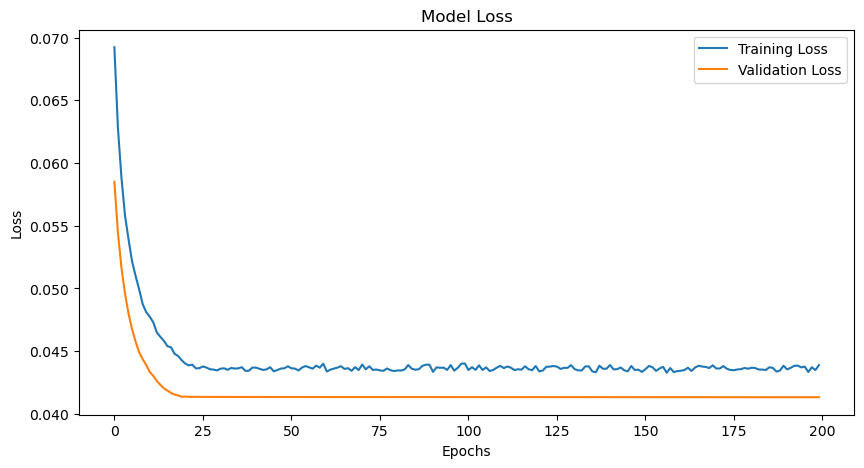

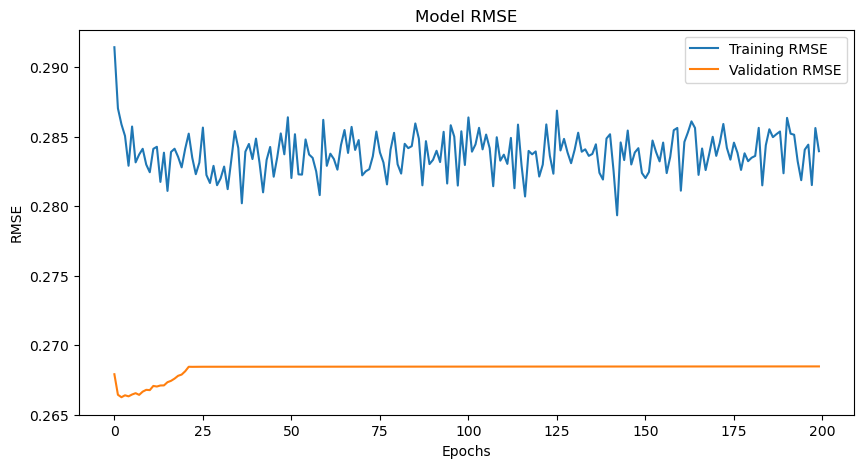

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Fungsi untuk preproses input dan menampilkan output rekomendasi berdasarkan filter

In [19]:
# fungsi untuk mengolah input agar format sesuai dengan model
def preprocess_user_input(user_input):
    # Buat DataFrame dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])

    # Normalisasi input pengguna menggunakan scaler
    normalized_input = scaler.transform(user_df)

    # Encode kategori dan kota
    user_category = encoder_category.transform([[user_input['category']]])
    user_city = encoder_city.transform([[user_input['city']]])

    # Gabungkan semua fitur
    user_vector = np.hstack((user_category, user_city, normalized_input))

    return user_vector


In [21]:
# fungsi untuk menampilkan top 5 rekomendasi berdasarkan input user
def recommend(user_input, top_n=5):
    # Preproses input pengguna
    user_input_vector = preprocess_user_input(user_input)

    # Prediksi score untuk masing-masing data
    scores = model.predict(X)
    data['score'] = scores.flatten()

    # Normalisasi nilai filter dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])
    normalized_input = scaler.transform(user_df)
    max_price_scaled, min_rating_scaled = normalized_input[0]

    # Filter data berdasarkan kriteria pengguna
    # Cek apakah kolom 'address' dan 'google_maps' ada sebelum difilter
    if 'address' in data.columns and 'google_maps' in data.columns:
        filtered_data = data[
            (data['rating'] >= min_rating_scaled) &
            (data['price_wna'] <= max_price_scaled) &
            (data['city'] == user_input['city']) &  # Filter berdasarkan kota
            (data['category'] == user_input['category']) & # Filter berdasarkan kategori
            (data['address'].notna())  # Filter data kosong
        ]
    else:
        # Jika kolom tidak ada, tampilkan warning
        print("Warning: 'address' column not found in data. Filtering without them.")
        filtered_data = data[
            (data['rating'] >= min_rating_scaled) &
            (data['price_wna'] <= max_price_scaled) &
            (data['city'] == user_input['city']) &  # Filter berdasarkan kota
            (data['category'] == user_input['category']) # Filter berdasarkan kategori
        ]


    # Kembalikan nilai rating dan price_wna ke skala asli
    if not filtered_data.empty:
        filtered_data.loc[:, ['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Ambil rekomendasi top-N
    if not filtered_data.empty:
        recommendations = filtered_data.nlargest(top_n, 'score')
    else:
        print("No recommendations found based on the given criteria.")
        recommendations = pd.DataFrame()  # DataFrame kosong jika tidak ada rekomendasi

    # Cek jika required columns ada di recommendations
    required_columns = ['name', 'rating', 'price_wna', 'city', 'category', 'address']
    available_columns = recommendations.columns.tolist()

    # Pilih kolom yang ada saja
    selected_columns = [col for col in required_columns if col in available_columns]

    return recommendations[selected_columns]

## Penggunaan input untuk rekomendasi berdasarkan filter

In [24]:
# Input dari pengguna
user_input = {
    "category": input("Enter the category of culinary : "),  # Contoh: "Bar"
    "city": input("Enter the city you want to go to : "),  # Contoh: "Denpasar" 
    "min_rating": float(input("Enter the minimum rating (0.0-5.0): ")),  # Contoh: 4.0
    "max_price": float(input("Enter the maximum ticket price (IDR) : "))  # Contoh: 50000
}

# Tampilkan rekomendasi
top_5_recommendations1 = recommend(user_input)
print(top_5_recommendations1)

Enter the category of culinary :  Bar
Enter the city you want to go to :  Denpasar
Enter the minimum rating (0.0-5.0):  4.5
Enter the maximum ticket price (IDR) :  300000


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
                       name  rating  price_wna      city category  \
60         Fisherman's Club     5.0   300000.0  Denpasar      Bar   
36             Lilla Pantai     4.5   300000.0  Denpasar      Bar   
292  Tree Bar at Maya Sanur     4.5   300000.0  Denpasar      Bar   
298         Pier Eight Bali     4.5   300000.0  Denpasar      Bar   
482     Shotgun Social Bali     4.5   300000.0  Denpasar      Bar   

                                               address  
60   Jalan Danau Tamblingan 89a Andaz Bali, Denpasa...  
36   Jalan Duyung Jalan Sanur Beach Street Walk, Sa...  
292  Jl. Danau Tamblingan 89M, Sanur, Denpasar 8022...  
298  Jalan Kusuma Sari No. 8, Sanur, Denpasar 80227...  
482  Jl. Pantai Sindhu No.11, Sanur, Denpasar 80228...  


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


## Fungsi untuk rekomendasi berdasarkan kuliner yang sebelumnya dikunjungi

In [26]:
# fungsi untuk rekomendasi berdasarkan kuliner yang telah dikunjungi
def recommend_similar_kuliner(kuliner_name, city_filter=None, max_price=None, top_n=5):
    # Pastikan nama tempat kuliner ada dalam data
    if kuliner_name not in data['name'].values:
        print(f"Tempat kuliner '{kuliner_name}' tidak ditemukan dalam data.")
        return pd.DataFrame()

    # Pilih fitur yang digunakan untuk perhitungan similarity
    features = np.hstack((
        encoded_category,
        encoded_city,
        data[['price_wna', 'rating']].values
    ))

    # Ambil indeks tempat kuliner yang diminta
    kuliner_idx = data[data['name'] == kuliner_name].index[0]

    # Hitung kesamaan menggunakan cosine similarity antara tempat kuliner input dengan semua tempat kuliner lainnya
    similarity_scores = cosine_similarity(features[kuliner_idx].reshape(1, -1), features).flatten()

    # Tambahkan skor kesamaan ke dalam DataFrame
    data['similarity'] = similarity_scores

    # Ubah tipe data max_price ke float jika tidak kosong
    if max_price is not None:
        max_price = float(max_price)

    # Filter data jika ada city_filter atau max_price
    filtered_data = data[data['name'] != kuliner_name]
    if city_filter:
        filtered_data = filtered_data[filtered_data['city'] == city_filter]
    if max_price is not None:
        # Normalisasi max_price untuk filter
        max_price_scaled = scaler.transform([[max_price, 0]])[0][0]
        filtered_data = filtered_data[filtered_data['price_wna'] <= max_price_scaled]

    # Kembalikan nilai rating dan price_wna ke skala aslinya
    if not filtered_data.empty:
        filtered_data.loc[:, ['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Urutkan berdasarkan skor similarity (descending) dan ambil top-N
    recommendations = filtered_data.nlargest(top_n, 'similarity') if not filtered_data.empty else pd.DataFrame()

    # Pilih kolom untuk ditampilkan
    return recommendations[['name', 'rating', 'price_wna', 'city', 'category', 'address', 'similarity']]


## Penggunaan input rekomendasi berdasarkan kuliner yang sebelumnya dikunjungi

In [29]:
# input dari user
kuliner_name = input("Enter the name of culinary you have already visited : ")
city_filter = input("Enter the city you want to go to (optional): ") or None
max_price = input("Enter the maximum price (optional): ") or None

# output
top_5_recommendations = recommend_similar_kuliner(kuliner_name, city_filter=city_filter, max_price=max_price)
print(top_5_recommendations)

Enter the name of culinary you have already visited :  Lilla Pantai
Enter the city you want to go to (optional):  
Enter the maximum price (optional):  


                            name  rating  price_wna      city category  \
292       Tree Bar at Maya Sanur     4.5   300000.0  Denpasar      Bar   
298              Pier Eight Bali     4.5   300000.0  Denpasar      Bar   
482          Shotgun Social Bali     4.5   300000.0  Denpasar      Bar   
532  Casablanca Dine Drink Dance     4.5   300000.0  Denpasar      Bar   
60              Fisherman's Club     5.0   300000.0  Denpasar      Bar   

                                               address  similarity  
292  Jl. Danau Tamblingan 89M, Sanur, Denpasar 8022...    1.000000  
298  Jalan Kusuma Sari No. 8, Sanur, Denpasar 80227...    1.000000  
482  Jl. Pantai Sindhu No.11, Sanur, Denpasar 80228...    1.000000  
532  Jl. Danau Tamblingan 120, Sanur, Denpasar 8022...    1.000000  
60   Jalan Danau Tamblingan 89a Andaz Bali, Denpasa...    0.985622  


In [31]:
model.save('Kuliner.h5')